In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# Inspect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [18]:
# Inspect column names and types
columns_measurement = inspector.get_columns('measurement')
for m in columns_measurement:
    print(m['name'],m['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [19]:
columns_station = inspector.get_columns('station')
for s in columns_station:
    print(s['name'],s['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [20]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [21]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [24]:
# Find the most recent date in the data set.
date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
date

'2017-08-23'

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.date(int(date.split('-')[0]),int(date.split('-')[1]),int(date.split('-')[2]))

# Calculate the date one year from the last date in data set.
query_date = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
one_year_prcp = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= query_date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
one_year_prcp = pd.DataFrame(one_year_prcp,columns=['Date','Precipitation'])
one_year_prcp = one_year_prcp[one_year_prcp['Precipitation'].notna()]
one_year_prcp.set_index('Date', inplace=True)

# Sort the dataframe by date
one_year_prcp = one_year_prcp.sort_values(['Date'])
one_year_prcp.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


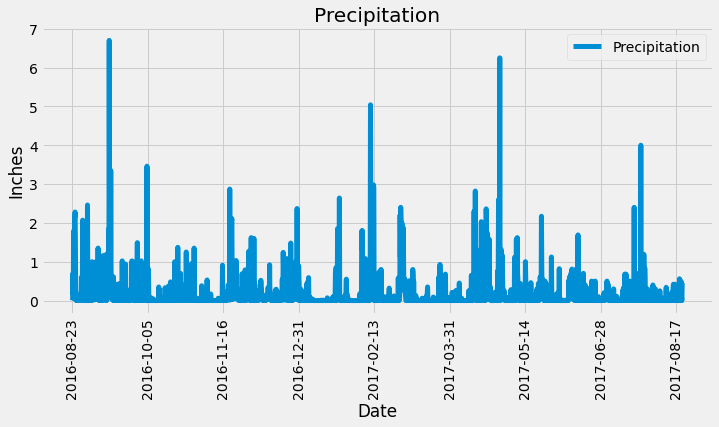

In [26]:
# Use Pandas Plotting with Matplotlib to plot the data
one_year_prcp.plot(figsize=(10,5),linewidth=5)
plt.tight_layout()
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.title('Precipitation')
plt.savefig('images/precipitation.png')
plt.show()

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_prcp.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number stations in the dataset
station_num = session.query(Station).count()
print(f'There are {station_num} stations')

There are 9 stations


In [29]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
count = func.count(Measurement.date)
most_active_station = session.query(Measurement.station,count).group_by(Measurement.station).order_by(count.desc()).first()
print(f'The most active station id is {most_active_station[0]} with {most_active_station[1]} rows')

The most active station id is USC00519281 with 2772 rows


In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station==most_active_station[0])
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station==most_active_station[0])
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station[0])
print(f'The lowest temp is {lowest_temp[0][0]}')
print(f'The highest temp is {highest_temp[0][0]}')
print(f'The average temp is {round(avg_temp[0][0],0)}')

The lowest temp is 54.0
The highest temp is 85.0
The average temp is 72.0


In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_temp = session.query(Measurement.date,Measurement.tobs).filter(Measurement.station==most_active_station[0]).filter(Measurement.date >= query_date).all()
one_year_temp = pd.DataFrame(one_year_temp,columns=['Date','TOBs'])
one_year_temp.set_index('Date', inplace=True)
one_year_temp.count()

TOBs    352
dtype: int64

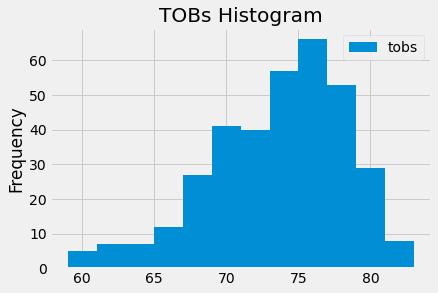

In [32]:
plt.hist(one_year_temp,bins=12,label="tobs")
plt.tight_layout()
plt.ylabel('Frequency')
plt.title('TOBs Histogram')
plt.legend(loc='upper right')
plt.savefig('images/station-histogram.png')
plt.show()

# Close session

In [33]:
# Close Session
session.close()